# ARIMA forecasting 📈

Objectives:
* Walk-through the steps involved in time series forecasting
* Introduce ARIMA models
* Use an arima model to make a forecast
* Excercise: Automatize the analysis


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates

import seaborn as sns
import matplotlib.style as style
# style.use('ggplot')

#!pip install pmdarima
import pmdarima as pmd
pmd.__version__  


'1.8.5'

# Example 1 - airline passenger forecasts ✈️ 💺

Our goal here is to forecast the number of air-travel passengers (per month) over the next 12 months using historical data.

Get the airline passenger data




In [2]:
from pmdarima.datasets import load_airpassengers

START_DATE = '1949-01-01'
airline = load_airpassengers(as_series=True)

#ajout d'un index datetime
airline.index= pd.date_range(START_DATE, periods=len(airline), freq='MS')

In [3]:
airline.describe()

count    144.000000
mean     280.298611
std      119.966317
min      104.000000
25%      180.000000
50%      265.500000
75%      360.500000
max      622.000000
dtype: float64

In [7]:
airline.head(10)
airline.tail(10)

1960-03-01    419.0
1960-04-01    461.0
1960-05-01    472.0
1960-06-01    535.0
1960-07-01    622.0
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Freq: MS, dtype: float64

In [5]:
airline.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Series name: None
Non-Null Count  Dtype  
--------------  -----  
144 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


Rather than a random train test split, when analysing time series data we must use the most recent data as the **testing set**.

TODO: Write a function which splits a dataset (a dataframe with time as index) and returns a train and test datasets, this function will have the split date as an argument.


In [8]:
import pandas as pd

## Write your code here
def ts_train_test_split(dataset,date_split):
    '''fonction qui a pour input un dataset et une date 
    de division de la base et pour outputs les deux datasets fusionnés'''
    
    
    train = airline['1949-01-01':date_split]
    test  = airline[date_split:]
    print('Train Dataset:',train.shape)
    print('Test Dataset:',test.shape)
    return train, test


In [9]:
#test de la fonction_split
date_split ='1949-01-01'
ts_train_test_split(airline,date_split)

Train Dataset: (1,)
Test Dataset: (144,)


(1949-01-01    112.0
 Freq: MS, dtype: float64,
 1949-01-01    112.0
 1949-02-01    118.0
 1949-03-01    132.0
 1949-04-01    129.0
 1949-05-01    121.0
               ...  
 1960-08-01    606.0
 1960-09-01    508.0
 1960-10-01    461.0
 1960-11-01    390.0
 1960-12-01    432.0
 Freq: MS, Length: 144, dtype: float64)

In [10]:
# split du dataset pour conserver uniquement les douze derniers mois
train, test = ts_train_test_split(airline, '1960-01-01')

Train Dataset: (133,)
Test Dataset: (12,)


In [11]:
train
test

1960-01-01    417.0
1960-02-01    391.0
1960-03-01    419.0
1960-04-01    461.0
1960-05-01    472.0
1960-06-01    535.0
1960-07-01    622.0
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Freq: MS, dtype: float64

## Explore TRAIN data

Like any prediction process we explore the data set to gain insights. But (as always) we only plot the TRAIN data! 

<AxesSubplot:>

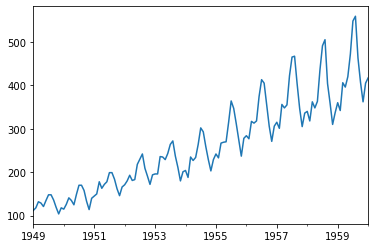

In [12]:
train.plot()

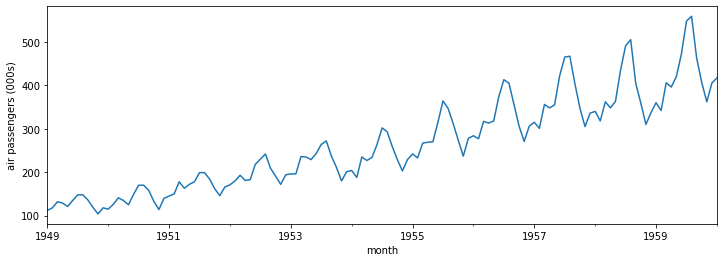

In [10]:
ax = train.plot(figsize=(12,4))
ax.set(xlabel='month', ylabel='air passengers (000s)');

Different months have different numbers of days. Soetimes we need to do what we can to make things easier for our model. Calcuating number of passengers per day might help remove some variation from the series...

In [16]:
train.index.days_in_month

Int64Index([31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
            ...
            30, 31, 30, 31, 31, 30, 31, 30, 31, 31],
           dtype='int64', length=133)

In [15]:
train

1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1959-09-01    463.0
1959-10-01    407.0
1959-11-01    362.0
1959-12-01    405.0
1960-01-01    417.0
Freq: MS, Length: 133, dtype: float64

In [14]:
train/train.index.days_in_month

1949-01-01     3.612903
1949-02-01     4.214286
1949-03-01     4.258065
1949-04-01     4.300000
1949-05-01     3.903226
                ...    
1959-09-01    15.433333
1959-10-01    13.129032
1959-11-01    12.066667
1959-12-01    13.064516
1960-01-01    13.451613
Freq: MS, Length: 133, dtype: float64

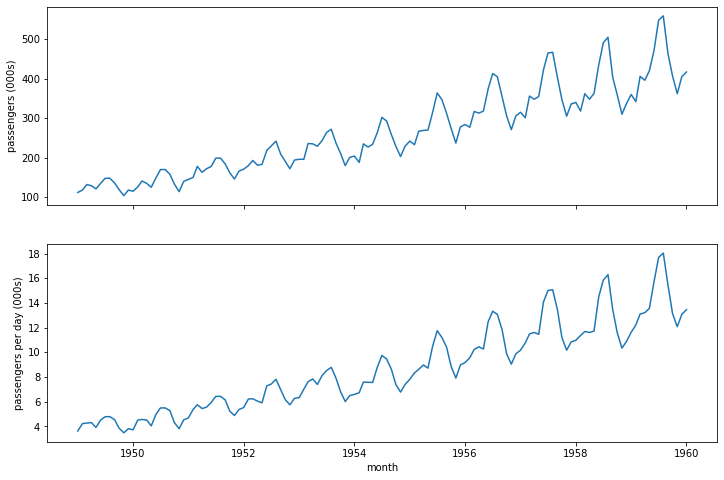

In [12]:
# ajustement des nombre de jours par mois avec la librairie pd.PeriodIndex
train_adj = train / train.index.days_in_month
test_adj = test / test.index.days_in_month

#plot les series ajustées (avec le nombre de jour correspondant) et non ajustées
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

axes[0].figsize = (12, 10)

axes[0].plot(train)
axes[0].set(ylabel='passengers (000s)');

axes[1].plot(train_adj)
axes[1].set(xlabel='month', ylabel='passengers per day (000s)');


<AxesSubplot:>

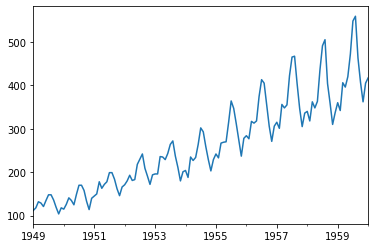

In [13]:
#plot les series ajustées (avec le nombre de jour correspondants à chaque mois) et non ajustées
train.plot()

<AxesSubplot:>

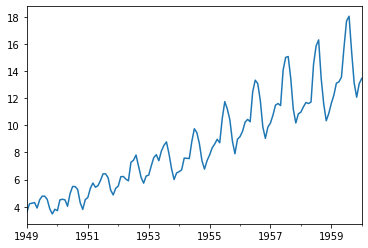

In [14]:
train_adj.plot()

#### Explore subcomponents in series.

Before performing a forecast it is worth decomposing the time series into its components of trend, seasonality and noise.

* statsmodels has function called `seasonal_decompose()` for this task

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [16]:
sd_result = seasonal_decompose(train_adj, model='multiplicative')

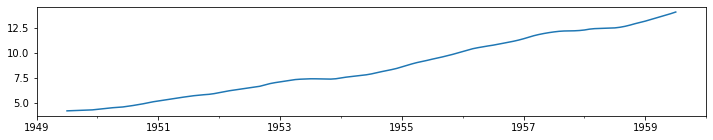

In [17]:
ax = sd_result.trend.plot(figsize=(12,2))

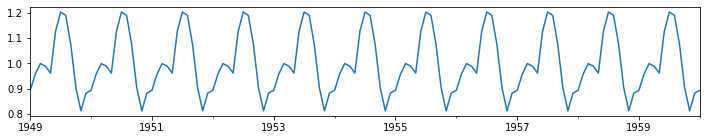

In [18]:
ax = sd_result.seasonal.plot(figsize=(12,2))

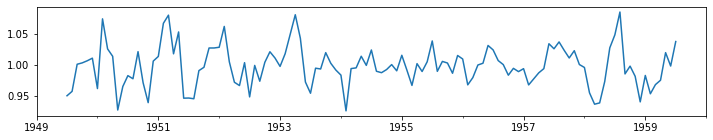

In [19]:
ax = sd_result.resid.plot(figsize=(12,2))

## Naive forecasting

We need a baseline (as always!) to know if our more complex models are any use! We explore two here:
* seasonal naive - a model which just takes the same period from the previous season. ( in this case the same month last year)
* naive - just carry forward the last value in the series

Given the strong seasonal component that was confirmed by the seasonal decomposition it may be a good idea to use a **seasonal naive** forecasting method.  This is part of the 'carry forward previous values' family of *naive* forecasting methods.  In general, if we have data with period $k$ are at time $t$ and we are predicting time $Y_{t+1}$ then we simply carry forward the value from $Y_{t+1-k}$. In other words we have yearly data so we just take the value from the same month last year.

In [19]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series

airline.index = pd.PeriodIndex(airline.index, freq="M")
y_train, y_test = temporal_train_test_split(airline, test_size=12)

In [22]:
fh = ForecastingHorizon(airline.index, is_relative=False)

In [25]:
fh

ForecastingHorizon(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
             '1949-07', '1949-08', '1949-09', '1949-10',
             ...
             '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
             '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', length=144, is_relative=False)

In [26]:
# using seasonal naive
forecaster = NaiveForecaster(strategy='last',sp=12) # ,window_length=None

To see what this is doing lets plot its predictions for the whole TRAIN data set to which it has been fitted.

In [27]:
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict()

/home/fernando.arroyo@Digital-Grenoble.local/anaconda3/lib/python3.9/site-packages/sktime/forecasting/base/_base.py:956: UserWarning: empty y passed to update_predict, no update was carried out
  warn("empty y passed to update_predict, no update was carried out")


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

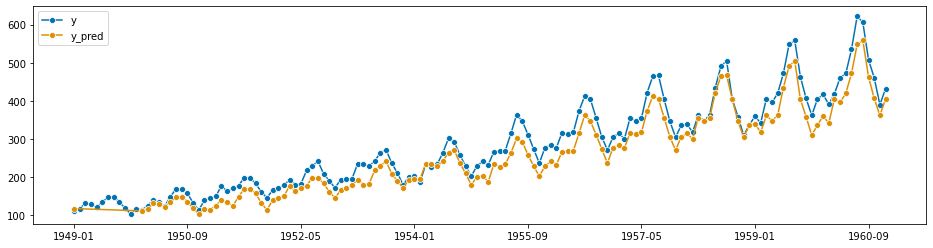

In [28]:
# plotting predictions and past data
plot_series(airline, y_pred, labels=["y", "y_pred"])

Plotting the **residuals** can give us information about how the model is performing and the errors it is making.  Sometimes there are reffered to as **in sample** diagnostics. This just means we are looking at diagnostics of data which has been used to fit the model. 

In [25]:
#See to add labels etc

/home/alexandra.penin@Digital-Grenoble.local/anaconda3/lib/python3.9/site-packages/sktime/forecasting/base/_base.py:956: UserWarning: empty y passed to update_predict, no update was carried out
  warn("empty y passed to update_predict, no update was carried out")


<AxesSubplot:>

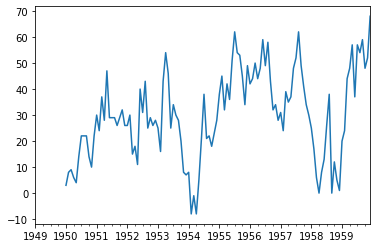

In [26]:
forecaster.predict_residuals().plot()

/home/alexandra.penin@Digital-Grenoble.local/anaconda3/lib/python3.9/site-packages/sktime/forecasting/base/_base.py:956: UserWarning: empty y passed to update_predict, no update was carried out
  warn("empty y passed to update_predict, no update was carried out")
/home/alexandra.penin@Digital-Grenoble.local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

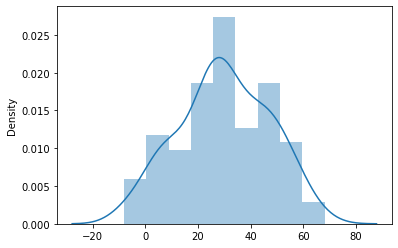

In [27]:
sns.distplot(forecaster.predict_residuals().dropna())

#### evaluating error

In the past we have done this. 

In [28]:
from sklearn.metrics import mean_squared_error

In [29]:
np.sqrt(mean_squared_error(train_adj[PERIOD:], insample_predictions[PERIOD:])) # we do not have predictions for the first period

NameError: name 'PERIOD' is not defined

For timeseries there are other approaches...

RMSE and MAE are called 'scale dependent' measures as the units and magnitude are specific to the problem and context.  An alternative approach is to use a scale invariant measure such as the **mean absolute percentage error (MAPE)**

The percentage error is given by $p_t = 100e_t/y_t$ where $e_t$ is the error in predicting $y_t$.  Therefore, MAPE = $mean(|p_t|)$. A limitation of MAPE is that it is inflated when the denominator is small relative to the absolute forecast error (such in the case of outliers or extreme unexpected events). It is also penalises negative errors more than positive errors.  A consequence of this property is that MAPE can lead to selecting a model that tends to under forecast.  The two following examples illustrate the issue. $$APE_{1} = \left| \frac{y_t - \hat{y_t}}{y_t} \right|= \left| \frac{150 - 100}{150} \right| = \frac{50}{150} = 33.33\%$$  

$$APE_{2} = \left| \frac{100 - 150}{100} \right| = \frac{50}{100} = 50\%$$

In [30]:
def mean_absolute_percentage_error(y_true, y_pred): 
    '''
    MAPE

    Parameters:
    --------
    y_true -- np.array actual observations from time series
    y_pred -- the predictions to evaluate

    Returns:
    -------
    float, scalar value representing the MAPE (0-100)
    '''
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
mean_absolute_percentage_error(airline[12:], y_pred[12:])

11.24871264156842

## Task: Perform the same analysis for the naive prediction

* Have a go at using the `Naive1()` class.  It follows the same pattern as SNaive interface.  Instantiate a class.  call the `.fit(y_train)` method and then use the `.fittedvalues` and `.resid` properties for diagnostics.  
* Calculate the in-sample RMSE and MAPE
* What happens to the insample residuals if you fit the raw training data to the model?

In [32]:
##### answer here




NOTE: The predictions we made above are only for the next step (month) in each timeseries! (not for the next 12 months) This means they are not correctly evaluating the error that we need for the specific task at hand. You can imagine for the simple naive model that a 12 month prediction actually looks like a flat line (using the most recent value). We will see this later.

## ARIMA

Let's try an ARIMA model at last. Using a classical statsitical approach you would select the order of model which produces a model with acceptable residual plots (remember the first part of linear regression module?). Selecting the best model can also be done automatically using packages which do it for you! Wohoo! 🎉

The `pmdarima` package is an excellent forecasting library for building ARIMA models.  I recommend it over and above the options available in core `statsmodels` package.  It is easier to use and offers an `auto_arima()` function that iteratively searches for a model that minimises the **Akaike Information Criterion (AIC)**

* ${\displaystyle \mathrm {AIC} \,=\,2k-2\ln({\hat {L}})}$

where $k$ = number of parameters in the model and $\hat{L}$ is the maximum value of the likelihood function for the model.  A likelihood function measures the 'goodness' of fit of a model to data given a set of parameters.  

This looks very complicated at first, but all we need to remember that the models we are working with are very flexible. This means that we can easily create complex models that overfit. Recall that overfitting is when a model will predict the training data exceptionally well, but will perform poorly on out of sample data.  The form of AIC means that it rewards models that fit the training data well, but also penalises models with high $k$ (complicated models with lots of parameters).  That means that AIC will prefer simpler models - in turn reducing overfitting.  That's a great formaula for automatically selecting a good ARIMA forecasting model.

There's a large amount of theory about how to build an ARIMA model.  But modern applications tend to opt for the auto approach.

In [29]:
from pmdarima.arima import auto_arima

ARIMA models require data to be stationary. Stationarity includes that both the mean and variance do not change over time. ARIMA models can take into account an increasing mean over time, however not the variance. We therefore need another transformation. A log transformation will take care of this.

In [34]:
train_adj_log = np.log(train_adj)

#select a model that minimises AIC


In [37]:
arima_model = auto_arima(train_adj_log, seasonal=True, m=12, suppress_warnings=True)

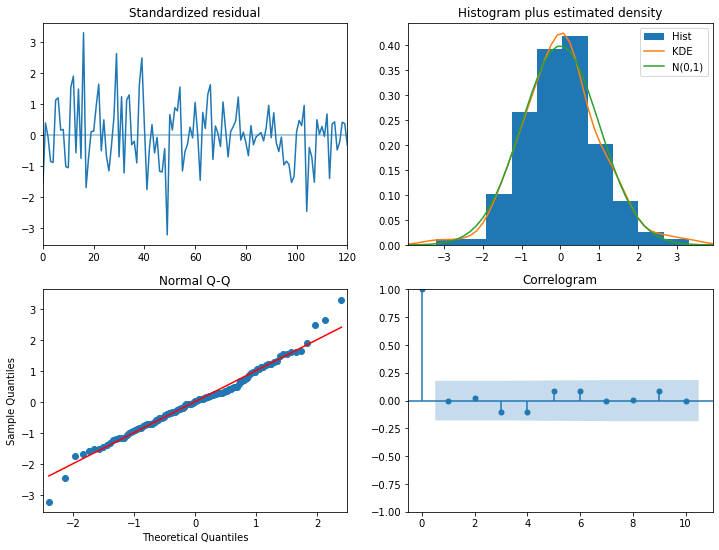

In [36]:
arima_model.plot_diagnostics(figsize=(12,9));

The best model selected is of order (2, 0, 0)x(0, 1, 1, 12) (and the residuals look acceptable). We will use these model in cross validation to estimate our model performance.

We can also specify a model with specific parameters as below.

In [38]:
from pmdarima.arima import ARIMA

In [39]:
model = ARIMA(order=(2,0,0), seasonal_order=(0, 1, 1, 12), suppress_warnings = True)

In [40]:
model.fit(train_adj_log)

ARIMA(order=(2, 0, 0), seasonal_order=(0, 1, 1, 12), suppress_warnings=True)

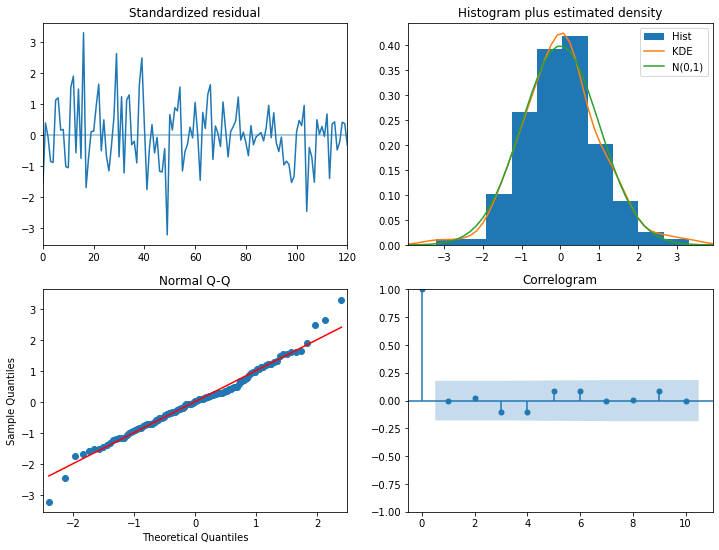

In [41]:
model.plot_diagnostics(figsize=(12,9));

## Time series cross-validation

In reality we would use some sort of cross validation. However, we must be careful when using time series which approach we use. We must be careful not to give the model any information from the future that it would not otherwise have at the time of making a forecast. This means we cannot use the standard CV methods which randomise our data that we have used in the past.

In the classicial time series literature time series cross validation is called a **Rolling Forecasting Horizon**. This is explained in details [here](https://robjhyndman.com/hyndsight/tscv/)

## Timeseries CV with naive models on  airline data

In order to choose between our models we use CV to estimate how we think each will perform on new data.

### Naive models

In [30]:
from sktime.forecasting.model_selection import SlidingWindowSplitter, ForecastingGridSearchCV, ExpandingWindowSplitter
from datetime import timedelta
from sktime.forecasting.model_evaluation import evaluate

In [31]:
airline = load_airpassengers(as_series=True)
y_train, y_test = temporal_train_test_split(airline, test_size=12)

In [32]:
param_grid = {"strategy" : ["last", "mean", "drift"]}

In [33]:
forecaster = NaiveForecaster(sp=12)
fh = ForecastingHorizon(y_train.index, is_relative=False)
cv = SlidingWindowSplitter(window_length=12, fh=list(range(1,25)), step_length = 24)

In [46]:
gscv = ForecastingGridSearchCV(forecaster=forecaster, param_grid=param_grid, cv=cv)
gscv.fit(y_train)
y_pred = gscv.predict(fh)

/home/alexandra.penin@Digital-Grenoble.local/anaconda3/lib/python3.9/site-packages/sktime/forecasting/naive.py:148: UserWarning: For the `drift` strategy, the `sp` value will be ignored.
  warn("For the `drift` strategy, the `sp` value will be ignored.")
/home/alexandra.penin@Digital-Grenoble.local/anaconda3/lib/python3.9/site-packages/sktime/forecasting/naive.py:148: UserWarning: For the `drift` strategy, the `sp` value will be ignored.
  warn("For the `drift` strategy, the `sp` value will be ignored.")
/home/alexandra.penin@Digital-Grenoble.local/anaconda3/lib/python3.9/site-packages/sktime/forecasting/naive.py:148: UserWarning: For the `drift` strategy, the `sp` value will be ignored.
  warn("For the `drift` strategy, the `sp` value will be ignored.")
/home/alexandra.penin@Digital-Grenoble.local/anaconda3/lib/python3.9/site-packages/sktime/forecasting/naive.py:148: UserWarning: For the `drift` strategy, the `sp` value will be ignored.
  warn("For the `drift` strategy, the `sp` value

In [47]:
min(gscv.cv_results_.mean_test_MeanAbsolutePercentageError)

0.14680211442494714

In [48]:
gscv.best_params_

{'strategy': 'drift'}

/home/alexandra.penin@Digital-Grenoble.local/anaconda3/lib/python3.9/site-packages/sktime/forecasting/base/_base.py:1740: UserWarning: NotImplementedWarning: NaiveForecaster does not have a custom `update` method implemented. NaiveForecaster will be refit each time `update` is called with update_params=True.
  warn(
/home/alexandra.penin@Digital-Grenoble.local/anaconda3/lib/python3.9/site-packages/sktime/forecasting/base/_base.py:1740: UserWarning: NotImplementedWarning: NaiveForecaster does not have a custom `update` method implemented. NaiveForecaster will be refit each time `update` is called with update_params=True.
  warn(
/home/alexandra.penin@Digital-Grenoble.local/anaconda3/lib/python3.9/site-packages/sktime/forecasting/base/_base.py:1740: UserWarning: NotImplementedWarning: NaiveForecaster does not have a custom `update` method implemented. NaiveForecaster will be refit each time `update` is called with update_params=True.
  warn(
/home/alexandra.penin@Digital-Grenoble.local/a

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

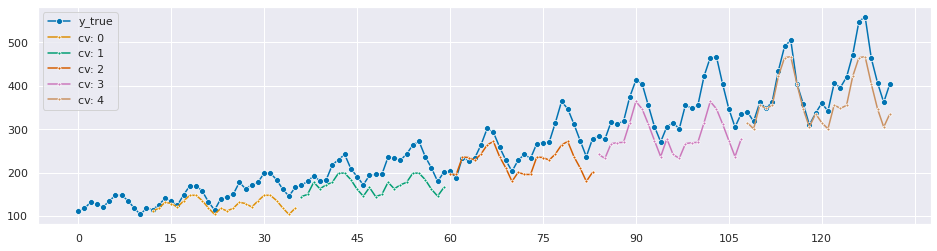

In [49]:
sns.set(rc={'figure.figsize':(12,6)})
cv_df = evaluate(forecaster=forecaster, 
                 y=y_train, cv=cv, 
                 strategy="update", 
                 return_data=True)

n=5
plot_series(y_train, 
            *[cv_df["y_pred"].iloc[x] for x in range(n)],
            markers=["o", *["."]*n],
            labels=["y_true"] + [f"cv: {x}" for x in range(n)])

The prediction is better for the seasonal-naive forecast. We would choose this as our baseline.

### CV with ARIMA

In [34]:
from pmdarima.arima import ARIMA
from pmdarima.model_selection import RollingForecastCV, cross_val_score

In [35]:
#manually create the arima model
model = ARIMA(order=(2,0,0), seasonal_order=(0, 1, 1, 12), suppress_warnings = True)

In [36]:
cv = RollingForecastCV(h=HORIZON, step=10) # initially uses 1/3 of the training size

NameError: name 'HORIZON' is not defined

In [55]:
#for cv need all of the training data joined together.
airline_adj = airline / airline.index.days_in_month
# airline_adj = np.log(airline_adj) # transform
train, test = ts_train_test_split(airline_adj, '1960-01-01')
train_log, test_log = np.log(train), np.log(test) # get logged values for arima model

cv_results = cross_val_score(model, train_log, cv=cv, scoring=mean_absolute_percentage_error)

AttributeError: 'RangeIndex' object has no attribute 'days_in_month'

In [ ]:
cv_results

In [ ]:
#how many splits did we get?
len(cv_results)

In [ ]:
pd.DataFrame(cv_results).dropna().describe()

This is a far better model that either of the naive results. We would choose this model over the others. Is it suitable for use in practice?.... ca depend...

**TASK**
* go back and try different step values in the RollingForecastCV
* What changes?
* In each case what size is the data is the model training on?

# Predictions and evaluation on the TEST

In [ ]:
airline.tail()

In [ ]:
train.tail()

In [ ]:
# predict 12-steps ahead with naive models
HORIZON = 12

nf1 = NaiveForecaster(strategy='drift')
nf1.fit(train)
nf1_preds = nf1.predict(fh=HORIZON)
snf.fit(train)
snf_preds = snf.predict(fh=HORIZON)

In [ ]:
# predict 12 steps ahead with arima
model.fit(train_log)
arima_preds = model.predict(12)

#### need to back transform the log traisform
arima_preds = np.exp(arima_preds)

In [ ]:
#plot the model predictions
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10, 6))

axes.plot(test)
axes.plot(pd.Series(nf1_preds, index=test.index));
axes.plot(pd.Series(snf_preds, index=test.index));
axes.plot(pd.Series(arima_preds, index=test.index));
axes.set(ylabel='passengers per day(000s)');
axes.legend(['test data', 'Naive1', 'SNaive','ARIMA']);

## Produce final forecast with chosen model

We want to predict the next 12 steps after the data we currently have.

In [ ]:
# fit arima model to whole time series
airline_log = np.log(airline_adj)
model.fit(airline_log)

#make predictions for following 12 periods
final_forecast, cis = model.predict(HORIZON, 
                                    return_conf_int=True, 
                                    alpha=0.05)

#### need to back transform the log
final_forecast = np.exp(final_forecast)
cis = np.exp(cis)

In [ ]:
#create an datetime index for the forecast horizon
forecast_index = pd.date_range(start='1961-01-01', periods=HORIZON, freq='MS')

#plot the model with 90% predictions intervals
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].plot(airline_adj)
axes[0].plot(pd.Series(final_forecast, index=forecast_index));



axes[0].set(ylabel='passengers per day(000s)');

limits = pd.DataFrame(cis, index=forecast_index, columns=['lower', 'upper'])
axes[0].fill_between(forecast_index, limits['lower'], limits['upper'], 
                  alpha=.3, 
                  label='90% PI')

axes[0].legend(['Existing data', 'Forecast', '95% PI']);



axes[1].plot(pd.Series(final_forecast, index=forecast_index));
axes[1].set(ylabel='passengers per day(000s)');

axes[1].fill_between(forecast_index, limits['lower'], limits['upper'], 
                  alpha=.1, 
                  label='90% PI', color='blue')

axes[1].legend(['Forecast', '95% PI']);

# Excercise 1 - Automatize the analysis

TODO: Write a class with the following methods:
* The necessary arguments to split the dataset, fit the auto_arima model etc.
* A `fit` method which fits the auto_arima naive and snaive models using a train dataset
* A `get_metrics` method which computes the MAPE for each models using a test dataset
* A `predict` method which takes as input a prediction horizon and returns predicted values.
* A `plot` method which plots the data, and if available the predictions 

Bonus: 
* Add a method get_cv Which performs cross validation
* To further automatize the process add an automatic detection of the period.
* Add the possibility to apply a preprocessing of the data before the fit: such as a log transformation.




In [ ]:
#### Write your code here

TODO: Test this method on all the other [11 datasets](https://alkaline-ml.com/pmdarima/modules/classes.html#module-pmdarima.datasets) of pmdarima. To help you, we provide the list of dataset names and a function to load any of these datasets.

On some of them the method does not work well, why? What could be done to improve it?

In [ ]:
import pmdarima

dataset_names = ['airpassengers', 'ausbeer', 'austres', 'gasoline', 'heartrate', 'lynx', 'msft', 'sunspots', 'taylor', 'wineind', 'woolyrnq']
def get_ds(ds_name, red_factor=None):
    '''
    Loads a dataset of pmdarima from its ds_name.
    '''
    ds = getattr(pmdarima.datasets, 'load_'+ds_name)(as_series=True).dropna()
    if red_factor is not None:
        assert isinstance(red_factor, int)
        ds= ds.groupby(np.arange(ds.index.shape[0])//red_factor).mean()
    return ds

In [ ]:
#### Write your code here

# Mémo perso?